In [1]:
%matplotlib inline

In [11]:
import numpy as np
import nibabel as nb
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist
from brainsmash.mapgen.sampled import Sampled
from brainsmash.mapgen.memmap import txt2memmap
from brainsmash.mapgen.eval import sampled_fit

https://brainsmash.readthedocs.io/en/latest/gettingstarted.html#getting-started

In [3]:
data_dir = '/home/julia/data/gradients/'

### Create a Eucledian distance map between all pairs of voxels in the cortex mask

In [4]:
# Load cortex mask
cortex = np.asanyarray(nb.load(data_dir + 'allen_atlas/cortex_mask_tight_200um.nii.gz').dataobj)

In [5]:
# Make an mx3 array where each of the m entries refers to the coordinate of one voxel included in the cortex mask
coords = np.asarray(np.where(cortex==1)).T

In [6]:
# Calculate Euclidean distance matrix (upper triangle)
dist_triu = pdist(coords, metric='euclidean')
# Construct full matrix
dist = np.zeros(shape=(coords.shape[0], coords.shape[0]))
dist[np.triu_indices(coords.shape[0], k=1)] = dist_triu
dist += dist.T
# Write to disk
np.savetxt(data_dir + 'results/null_models/volume/cortex_euclidean.txt', dist)

In [6]:
dist = np.loadtxt(data_dir + 'results/null_models/volume/cortex_euclidean.txt')

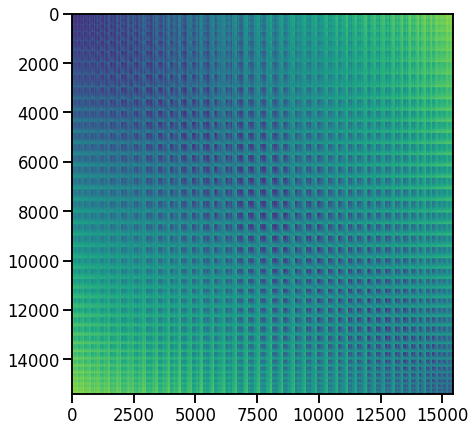

In [7]:
sns.set_context('talk')
fig=plt.figure(figsize=(7,7))
plt.imshow(dist)

### Create memory mapped arrays

In [8]:
output_files = txt2memmap(data_dir+"results/null_models/volume/cortex_euclidean.txt", 
                          data_dir+"results/null_models/volume", 
                          maskfile=None, delimiter=' ')

### Check and combine surrogates ran on cluster

In [27]:
# Load, reshape and save
for z in range(6):
    surrogates = []
    emp_var_samples = []
    surr_var_samples = []
    u0_samples = []
    for n in range(10):
        surr_dict = pickle.load(open(data_dir+'results/null_models/volume/surrogates/vol{}_n{}.pkl'.format(z,n), 'rb'))
        surrogates.append(surr_dict['maps'])
        emp_var_samples.append(surr_dict['emp_var'])
        surr_var_samples.append(surr_dict['surr_var'])
        u0_samples.append(surr_dict['u0'])


    emp_var_samples = np.asarray(emp_var_samples).reshape(10000,25)
    surr_var_samples = np.asarray(surr_var_samples).reshape(10000,25)
    u0_samples = np.asarray(u0_samples).reshape(10000,25)
    surrogates = np.asarray(surrogates).reshape(10000, 15422)
    
    np.save(data_dir+'results/null_models/volume/surrogates/vol{}_emp_var.npy'.format(z), emp_var_samples)
    np.save(data_dir+'results/null_models/volume/surrogates/vol{}_surr_var.npy'.format(z), surr_var_samples)
    np.save(data_dir+'results/null_models/volume/surrogates/vol{}_u0.npy'.format(z), u0_samples)
    np.save(data_dir+'results/null_models/volume/surrogates/vol{}_surrogates.npy'.format(z), surrogates)

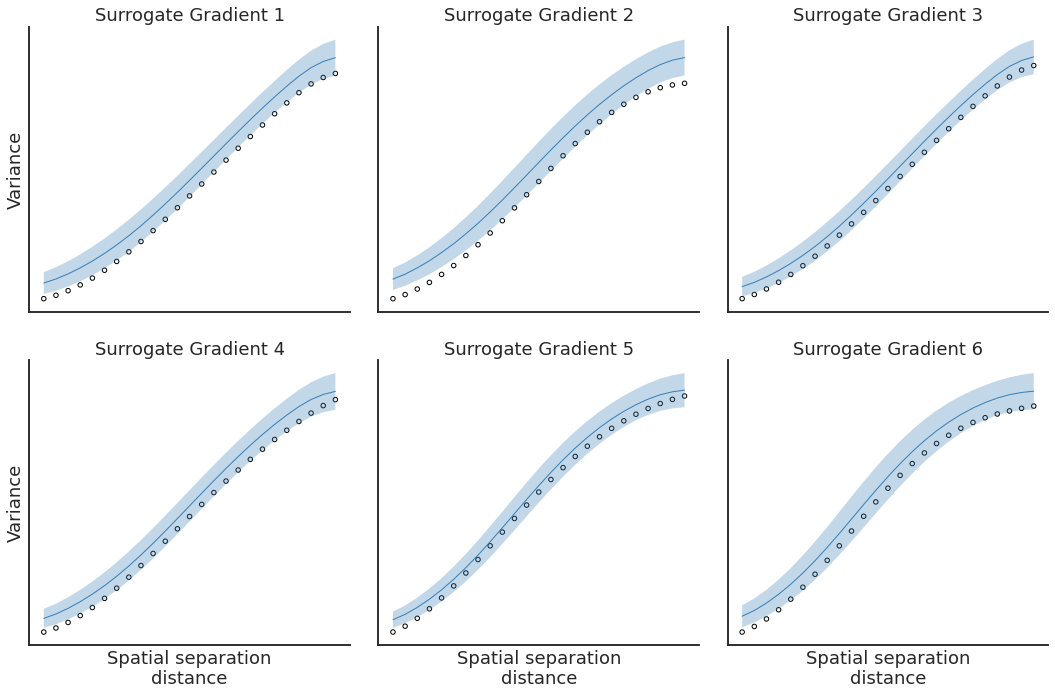

In [28]:
# Plot variograms
sns.set_style('ticks')
sns.set_context('talk')
fig = plt.figure(figsize=(15, 10))

for z in range(6):
    
    emp_var_samples = np.load(data_dir+'results/null_models/volume/surrogates/vol{}_emp_var.npy'.format(z))
    surr_var_samples = np.load(data_dir+'results/null_models/volume/surrogates/vol{}_surr_var.npy'.format(z))
    u0_samples = np.load(data_dir+'results/null_models/volume/surrogates/vol{}_u0.npy'.format(z))

    emp_var = emp_var_samples.mean(axis=0)
    u0 =  u0_samples.mean(axis=0)
    mu = surr_var_samples.mean(axis=0)
    sigma = surr_var_samples.std(axis=0)
    
    ax = fig.add_subplot(2,3,z+1)
    ax.scatter(u0, emp_var, s=20, facecolor='none', edgecolor='k',marker='o', lw=1, label='Empirical')
    ax.fill_between(u0, mu-sigma, mu+sigma, facecolor='#377eb8',edgecolor='none', alpha=0.3)
    ax.plot(u0, mu, color='#377eb8', label='SA-preserving', lw=1)
    plt.xticks([])
    plt.yticks([])
    
    if z in [0,3]:
        plt.ylabel("Variance")
    if z>2:
        plt.xlabel("Spatial separation\ndistance")
    if z==6:
        leg = ax.legend(loc=0)
    plt.title('Surrogate Gradient {}'.format(z+1))
    sns.despine()
    plt.tight_layout()